# Image Classification using ImageNette + depth

> Image Classification using ImageNette + depth


- skip_showdoc: true
- skip_exec: true

## Data Preprocessing

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class ComputeFFT(object):
    def __init__(self):
        super().__init__()
    
    def __call__(self, image):
        # Convert the color image to grayscale
        grayscale_image = TF.rgb_to_grayscale(image).squeeze()
        
        # Convert the grayscale image to tensor and apply FFT
        fft_result = torch.fft.fft2(grayscale_image)
        
        # Compute magnitude spectrum
        magnitude_spectrum = torch.log(torch.abs(fft_result) + 1)
        
        # Compute phase spectrum
        phase_spectrum = torch.angle(fft_result)
        
        combined_image = torch.cat((image, magnitude_spectrum.unsqueeze(0), phase_spectrum.unsqueeze(0)), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
# Define the transformations to apply to the images
# additional_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),            # Random resized crop
#     transforms.RandomHorizontalFlip(),            # Random horizontal flip
#     transforms.RandomRotation(10),                # Random rotation by 10 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
#     transforms.RandomErasing(),                   # Random erasing
# ])
transform_default = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    # ComputeFFT(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),  # Normalize with ImageNet mean and std
])

In [ ]:
transform_default

Compose(
    ToTensor()
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
    Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225])
)

In [ ]:
from pathlib import Path
from typing import Any, Callable, Optional, Tuple, Union

from PIL import Image

from torchvision.datasets.folder import find_classes, make_dataset
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg
from torchvision.datasets.vision import VisionDataset


class Imagenette(VisionDataset):
    """`Imagenette <https://github.com/fastai/imagenette#imagenette-1>`_ image classification dataset.

    Args:
        root (str or ``pathlib.Path``): Root directory of the Imagenette dataset.
        split (string, optional): The dataset split. Supports ``"train"`` (default), and ``"val"``.
        size (string, optional): The image size. Supports ``"full"`` (default), ``"320px"``, and ``"160px"``.
        download (bool, optional): If ``True``, downloads the dataset components and places them in ``root``. Already
            downloaded archives are not downloaded again.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed
            version, e.g. ``transforms.RandomCrop``.
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.

     Attributes:
        classes (list): List of the class name tuples.
        class_to_idx (dict): Dict with items (class name, class index).
        wnids (list): List of the WordNet IDs.
        wnid_to_idx (dict): Dict with items (WordNet ID, class index).
    """

    _ARCHIVES = {
        "full": ("https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz", "fe2fc210e6bb7c5664d602c3cd71e612"),
        "320px": ("https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz", "3df6f0d01a2c9592104656642f5e78a3"),
        "160px": ("https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz", "e793b78cc4c9e9a4ccc0c1155377a412"),
    }
    _WNID_TO_CLASS = {
        "n01440764": ("tench", "Tinca tinca"),
        "n02102040": ("English springer", "English springer spaniel"),
        "n02979186": ("cassette player",),
        "n03000684": ("chain saw", "chainsaw"),
        "n03028079": ("church", "church building"),
        "n03394916": ("French horn", "horn"),
        "n03417042": ("garbage truck", "dustcart"),
        "n03425413": ("gas pump", "gasoline pump", "petrol pump", "island dispenser"),
        "n03445777": ("golf ball",),
        "n03888257": ("parachute", "chute"),
    }

    def __init__(
        self,
        root: Union[str, Path],
        split: str = "train",
        size: str = "full",
        download=False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self._split = verify_str_arg(split, "split", ["train", "val"])
        self._size = verify_str_arg(size, "size", ["full", "320px", "160px"])

        self._url, self._md5 = self._ARCHIVES[self._size]
        self._size_root = Path(self.root) / Path(self._url).stem
        self._image_root = str(self._size_root / self._split)

        if download:
            self._download()
        elif not self._check_exists():
            raise RuntimeError("Dataset not found. You can use download=True to download it.")

        self.wnids, self.wnid_to_idx = find_classes(self._image_root)
        self.classes = [self._WNID_TO_CLASS[wnid] for wnid in self.wnids]
        self.class_to_idx = {
            class_name: idx for wnid, idx in self.wnid_to_idx.items() for class_name in self._WNID_TO_CLASS[wnid]
        }
        self._samples = make_dataset(self._image_root, self.wnid_to_idx, extensions=".png")

    def _check_exists(self) -> bool:
        return self._size_root.exists()

    def _download(self):
        if self._check_exists():
            raise RuntimeError(
                f"The directory {self._size_root} already exists. "
                f"If you want to re-download or re-extract the images, delete the directory."
            )

        download_and_extract_archive(self._url, self.root, md5=self._md5)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        path, label = self._samples[idx]
        image = Image.open(path).convert("RGBA")

        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label


    def __len__(self) -> int:
        return len(self._samples)

In [ ]:
from typing import Any
class Imagenette_v2(Imagenette):
    def __init__(self, *args, **kwargs):
        super(Imagenette_v2, self).__init__(*args, **kwargs)

        # self._samples = make_dataset(self._image_root, self.wnid_to_idx)
        

    
    def get_location(self, idx: int) -> [Any]:
        path, _ = self._samples[idx]

        return path

In [ ]:
# Download and load the Imagenette dataset
train_dataset = Imagenette_v2(root='Data/Imagenette_depth',
                                    split='train',
                                    # download=True,
                                    transform=transform_default,
                                    )


# Download and load the Imagenette dataset
test_dataset = Imagenette_v2(root='Data/Imagenette_depth',
                                  split='val',
                                  # download=True,
                                  transform=transform_default,
                                 )

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', '_split', '_size', '_url', '_md5', '_size_root', '_image_root', 'wnids', 'wnid_to_idx', 'classes', 'class_to_idx', '_samples'])

In [ ]:
train_dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
len(train_dataset), len(test_dataset)

(9469, 3925)

In [ ]:
images, labels = train_dataset[10]
images.shape

torch.Size([4, 150, 150])

In [ ]:
train_dataset.get_location(10)

'Data/Imagenette_depth/imagenette2/train/n01440764/ILSVRC2012_val_00011993.png'

In [ ]:

image_np = images[:3].numpy().transpose((1, 2, 0))
image_np.shape

(150, 150, 3)

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image[:3].numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np.clip(0,1))
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label][0]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image[:3].numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np.clip(0,1))
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

# Define a function to display images
def show_depth(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image[3].numpy()
        
        # Display image
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

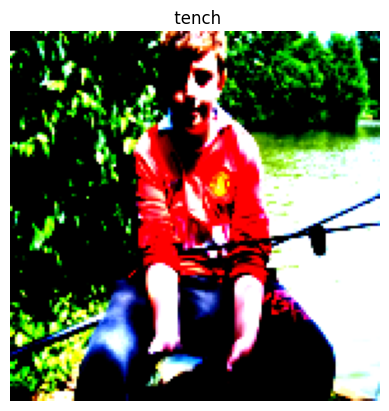

In [ ]:
show_image(train_dataset[2])

In [ ]:
def loaders(batch_size):

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False, 
                             num_workers=8)
    
    dataloaders = {'train': train_loader, 'val': test_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset) }
    return train_loader, test_loader, dataloaders, dataset_sizes

In [ ]:
batch_size = 32
train_loader, test_loader, dataloaders, dataset_sizes = loaders(batch_size)

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(test_loader)
images, labels = next(examples)
# ############## TENSORBOARD ########################
# img_grid = utils.make_grid(images)

# writer.add_image('Imagenette', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

In [ ]:
images.shape

torch.Size([32, 4, 150, 150])

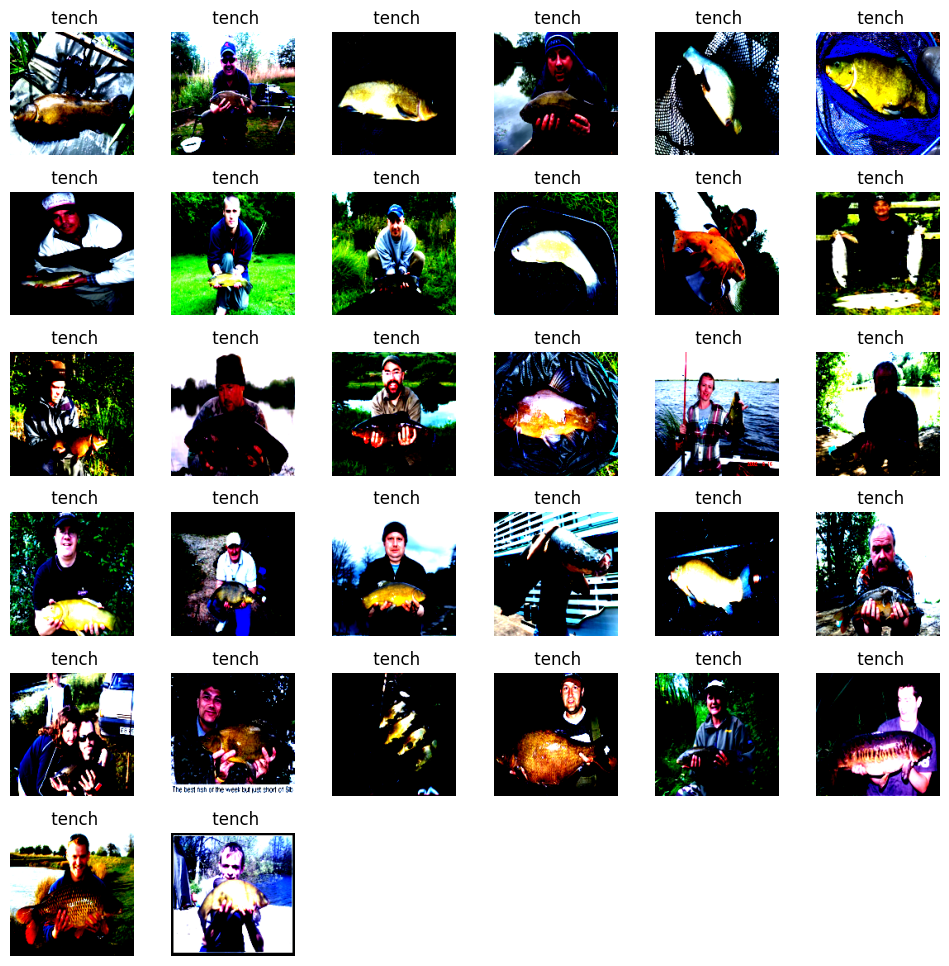

In [ ]:
show_images(images, labels)

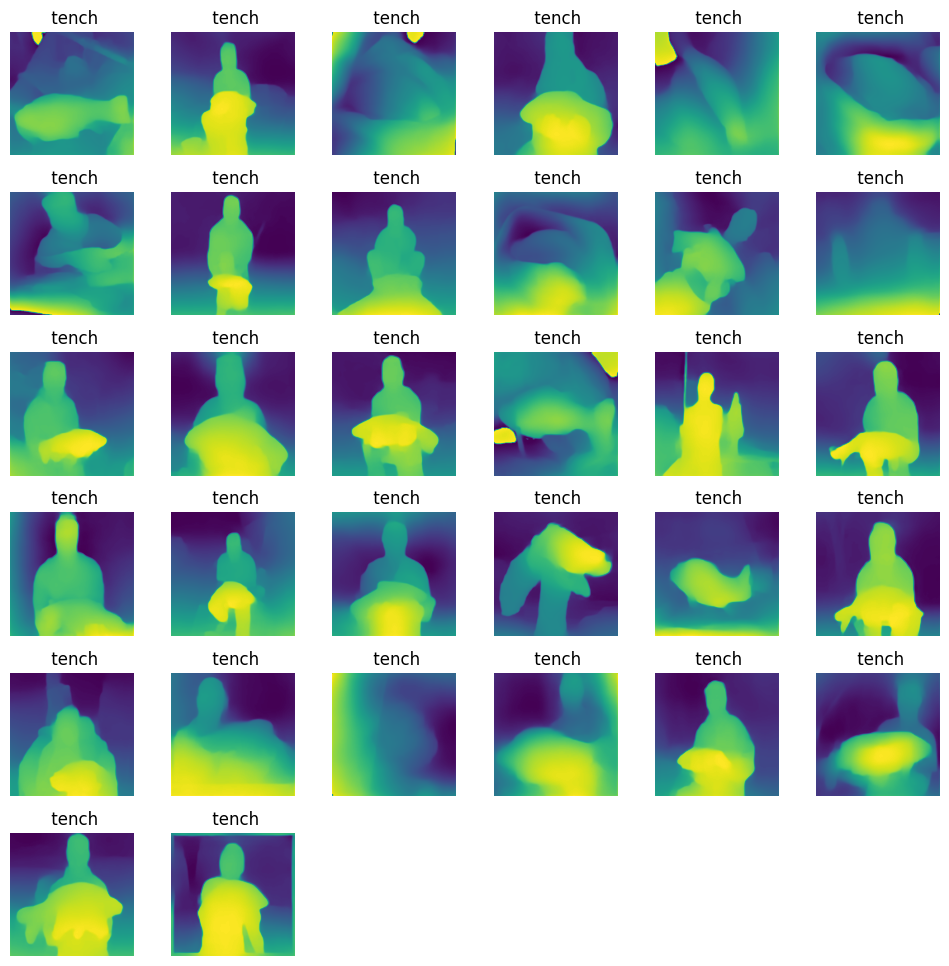

In [ ]:
show_depth(images, labels)

In [ ]:
images[1][1].shape

torch.Size([150, 150])

In [ ]:
images[1][3].max()

tensor(1.9215)

In [ ]:
images[1][3].min()

tensor(-1.0898)

## Model Training

In [ ]:
timm.list_models('resnet*')[:5]

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26']

In [ ]:
def create_custom_model(model_name: str,
                        pretrained: bool = False,
                        input_channels:int = 3,
                        **kwargs):
    model = timm.create_model(model_name,
                              pretrained=pretrained,
                              **kwargs)


    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) 

    return model


In [ ]:
model = create_custom_model('resnet18',
                            pretrained=True,
                            input_channels = 4,
                            num_classes=10)

In [ ]:
def train_model(model, criterion, 
                optimizer, scheduler, 
                train_loader, epoch,
                n_total_steps, record = 10):
    running_loss = 0.0
    running_correct = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % record == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / record, epoch * n_total_steps + i)
            running_accuracy = running_correct / record / len(images)
            writer.add_scalar('training accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            writer.flush()
            ###################################################
    scheduler.step()
    

def eval_model(model, criterion, 
               optimizer, scheduler, 
               test_loader, epoch,
               n_total_steps, batch_size):
    running_loss = 0.0
    running_correct = 0
    running_accuracy = 0
    
    model.eval()
    len_batch = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):  
        images = images.to(device)
        labels = labels.to(device)
        len_batch = len(images)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss',
                      running_loss / len(test_loader),
                      (epoch+1) * n_total_steps)
    running_accuracy = running_correct / len(test_loader) / batch_size
    writer.add_scalar('val accuracy',
                      running_accuracy,
                      (epoch+1) * n_total_steps)

    writer.flush()
    ###################################################

In [ ]:
def build_model(model, criterion, optimizer,
                scheduler, num_epochs=5, batch_size = 32, record = 10):
    
    train_loader, test_loader, _, _ = loaders(batch_size)

    model = model.to(device)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_model(model, criterion,
                    optimizer, scheduler,
                    train_loader, epoch,
                    n_total_steps, record = 10)

        eval_model(model, criterion, 
                   optimizer, scheduler, 
                   test_loader, epoch, 
                   n_total_steps, batch_size)

    return model

## default setup

In [ ]:
# model = timm.create_model('resnet18',
#                           pretrained=True,
#                           num_classes=10)


In [ ]:
# learning_rate = 0.1
# num_epochs = 5
# batch_size = 64
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# ############## TENSORBOARD ########################
# import sys
# from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# formatted_time =  datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# writer = SummaryWriter(log_dir = f'runs/transforms everything {formatted_time}')

# writer.add_text('learning_rate', f'{learning_rate}')
# writer.add_text('epochs', f'{num_epochs}')
# writer.add_text('batch_size', f'{batch_size}')
# writer.add_text('criterion', f'{str(criterion)}')
# writer.add_text('optimizer', f'{str(optimizer)}')

# writer.add_graph(model, images)
# writer.flush()
# ###################################################

In [ ]:
# model = build_model(model = model,
#                     criterion = criterion,
#                     optimizer = optimizer,
#                     scheduler = step_lr_scheduler,
#                     num_epochs = num_epochs,
#                     batch_size = batch_size,
#                     record = 20)

In [ ]:
# del model
# torch.cuda.empty_cache()

In [ ]:
# ############## TENSORBOARD ########################
# writer.close()
# ###################################################

## Test Loop

In [ ]:
learning_rate = 0.5
num_epochs = 9
batch_size = 64
criterion = nn.CrossEntropyLoss()

In [ ]:
for a in range(1):
    model = create_custom_model('resnet18',
                                pretrained=True,
                                input_channels = 4,
                                num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
    
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'runs/add depth resnet18 {num_epochs} {formatted_time}')
    print(f'runs/add FFT {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{num_epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    writer.add_text('criterion', f'{str(criterion)}')
    writer.add_text('optimizer', f'{str(optimizer)}')
    
    # writer.add_graph(model, images)
    writer.flush()
    ###################################################


    model = build_model(model = model,
                        criterion = criterion,
                        optimizer = optimizer,
                        scheduler = step_lr_scheduler,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        record = 20)
    del model
    torch.cuda.empty_cache()
    
    ######################## TENSORBOARD ########################
    writer.close()
    ###################################################


runs/add FFT 20:40:20


100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.46it/s]


## Model Summary 

In [ ]:
from torchinfo import summary

model = create_custom_model('resnet18',
                            pretrained=True,
                            input_channels = 4,
                            num_classes=10)

In [ ]:
summary(model, input_size=images.shape, verbose = 0, depth  = 5, col_names = (
                "input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                "mult_adds",
                "trainable",
            ))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
ResNet                                   [32, 4, 150, 150]         [32, 10]                  --                             --                   --                        --                        True
├─Conv2d: 1-1                            [32, 4, 150, 150]         [32, 64, 75, 75]          12,544                      0.11%                   [7, 7]                    2,257,920,000             True
├─BatchNorm2d: 1-2                       [32, 64, 75, 75]          [32, 64, 75, 75]          128                         0.00%                   --                        4,096                     True
├─ReLU: 1-3                              [32, 64, 75, 75]          [32, 64, 75, 75]          --                             --                   --                        --              